# Collaborative Filtering with Neural Networks

In this notebook we will write a matrix factorization model in pytorch to solve a recommendation problem. Then we will write a more general neural model for the same problem.

The MovieLens dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from MovieLens, a movie recommendation service. It contains 100004 ratings and 1296 tag applications across 9125 movies. https://grouplens.org/datasets/movielens/. To get the data:

`wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip`

## MovieLens dataset

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np

In [3]:
PATH = Path("ml-25m/")
#PATH = Path("/data2/yinterian/ml-latest-small/")
list(PATH.iterdir())

[PosixPath('ml-25m/genome-scores.csv'),
 PosixPath('ml-25m/movies.csv'),
 PosixPath('ml-25m/genome-tags.csv'),
 PosixPath('ml-25m/tags.csv'),
 PosixPath('ml-25m/README.txt'),
 PosixPath('ml-25m/links.csv'),
 PosixPath('ml-25m/original collaborative-filtering-nn.ipynb'),
 PosixPath('ml-25m/ratings.csv')]

In [4]:
data = pd.read_csv(PATH/"ratings.csv")

In [5]:
data.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


### Encoding data
We enconde the data to have contiguous ids for users and movies. You can think about this as a categorical encoding of our two categorical variables userId and movieId.

In [6]:
# split train and validation before encoding
np.random.seed(3)
msk = np.random.rand(len(data)) < 0.8
train = data[msk].copy()
val = data[~msk].copy()

In [7]:
# here is a handy function modified from fast.ai
def proc_col(col, train_col=None):
    """Encodes a pandas column with continous ids. 
    """
    if train_col is not None:
        uniq = train_col.unique()
    else:
        uniq = col.unique()
    name2idx = {o:i for i,o in enumerate(uniq)}
    return name2idx, np.array([name2idx.get(x, -1) for x in col]), len(uniq)

In [8]:
def encode_data(df, train=None):
    """ Encodes rating data with continous user and movie ids. 
    If train is provided, encodes df with the same encoding as train.
    """
    df = df.copy()
    for col_name in ["userId", "movieId"]:
        train_col = None
        if train is not None:
            train_col = train[col_name]
        _,col,_ = proc_col(df[col_name], train_col)
        df[col_name] = col
        df = df[df[col_name] >= 0]
    return df

In [9]:
# encoding the train and validation data
df_train = encode_data(train)
df_val = encode_data(val, train)

## Embedding layer

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

/home/kangjunekoo/anaconda3/envs/Pytorch2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
num_users = len(df_train.userId.unique())
num_items = len(df_train.movieId.unique())
print(num_users, num_items) 

162541 56642


In [12]:
global train_losses
train_losses=[]
def train_epocs(model, epochs=10, lr=0.01, wd=0.0, unsqueeze=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    model.train()
    for i in range(epochs):
        global users,items,ratings
        users = torch.LongTensor(df_train.userId.values) # .cuda()
        items = torch.LongTensor(df_train.movieId.values) #.cuda()
        ratings = torch.FloatTensor(df_train.rating.values) #.cuda()
        if unsqueeze:
            ratings = ratings.unsqueeze(1)
        y_hat = model(users, items)
        loss = F.mse_loss(y_hat, ratings)
        train_losses.append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print("epochs : ",i) 
        print("train loss %.3f " % loss.item()) 
        test_loss(model, unsqueeze)

In [13]:
# Here is what unsqueeze does
ratings = torch.FloatTensor(df_train.rating.values)
print(ratings.shape)
ratings = ratings.unsqueeze(1) # .cuda()
print(ratings.shape)

torch.Size([19999967])
torch.Size([19999967, 1])


In [14]:
import pandas as pd
global val_losses
val_losses=[]
def test_loss(model, unsqueeze=False):
    model.eval()
    global users,items,ratings,y_hat
    users = torch.LongTensor(df_val.userId.values) #.cuda()
    items = torch.LongTensor(df_val.movieId.values) #.cuda()
    ratings = torch.FloatTensor(df_val.rating.values) #.cuda()
    if unsqueeze:
        ratings = ratings.unsqueeze(1)
    y_hat = model(users, items)
    global df_users,df_items,df_y_hat,df_ratings
    df_users=pd.DataFrame(users.numpy())
    df_items=pd.DataFrame(items.numpy())
    df_y_hat=pd.DataFrame(y_hat.detach().numpy())
    df_ratings=pd.DataFrame(ratings.numpy())

    loss = F.mse_loss(y_hat, ratings)
    val_losses.append(loss)
    print("validation loss %.3f " % loss.item())

## Neural Network Model

In [15]:
# Note here there is no matrix multiplication, we could potentially make the embeddings of different sizes.
# Here we could get better results by keep playing with regularization.
    
class CollabFNet(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100, n_hidden=10):
        super(CollabFNet, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.lin1 = nn.Linear(emb_size*2, n_hidden)
        self.lin2 = nn.Linear(n_hidden, 1)
        self.drop1 = nn.Dropout(0.1)
        
    def forward(self, u, v):
        global U,V
        U = self.user_emb(u)
        V = self.item_emb(v)
        x = F.relu(torch.cat([U, V], dim=1))
        x = self.drop1(x)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

In [16]:
model = CollabFNet(num_users, num_items, emb_size=100) #.cuda()

In [17]:
train_epocs(model, epochs=30, lr=0.05, wd=1e-6, unsqueeze=True) 

epochs :  0
train loss 13.962 
validation loss 3.316 
epochs :  1
train loss 3.320 
validation loss 1.293 
epochs :  2
train loss 1.294 
validation loss 1.886 
epochs :  3
train loss 1.885 
validation loss 1.866 
epochs :  4
train loss 1.864 
validation loss 1.213 
epochs :  5
train loss 1.212 
validation loss 1.243 
epochs :  6
train loss 1.243 
validation loss 1.478 
epochs :  7
train loss 1.477 
validation loss 1.127 
epochs :  8
train loss 1.125 
validation loss 0.988 
epochs :  9
train loss 0.985 
validation loss 1.161 
epochs :  10
train loss 1.156 
validation loss 1.181 
epochs :  11
train loss 1.176 
validation loss 0.991 
epochs :  12
train loss 0.986 
validation loss 0.891 
epochs :  13
train loss 0.886 
validation loss 1.005 
epochs :  14
train loss 1.000 
validation loss 1.022 
epochs :  15
train loss 1.017 
validation loss 0.898 
epochs :  16
train loss 0.892 
validation loss 0.884 
epochs :  17
train loss 0.877 
validation loss 0.963 
epochs :  18
train loss 0.956 
valida

/home/kangjunekoo/anaconda3/envs/Pytorch2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/kangjunekoo/anaconda3/envs/Pytorch2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

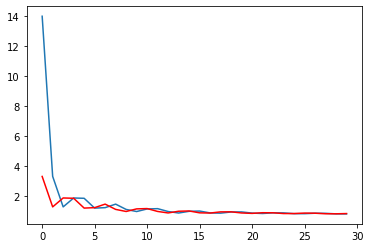

In [18]:
import seaborn as sns
train_losses_float=[float(train_loss.cpu().detach().numpy()) for train_loss in train_losses]
train_loss_indices=[i for i, l in enumerate(train_losses_float)]
plt=sns.lineplot(train_loss_indices,train_losses_float)
val_losses_float=[float(val_loss.cpu().detach().numpy()) for val_loss in val_losses]
val_loss_indices=[i for i, l in enumerate(val_losses_float)]
plt=sns.lineplot(val_loss_indices,val_losses_float,color='r')
plt

In [19]:
df_users.T

,0,1,2,3,4,5,6,7,8,9,...,4997311,4997312,4997313,4997314,4997315,4997316,4997317,4997318,4997319,4997320
0,0,0,0,0,0,0,0,0,1,1,...,162540,162540,162540,162540,162540,162540,162540,162540,162540,162540


In [20]:
df_items.T

,0,1,2,3,4,5,6,7,8,9,...,4997311,4997312,4997313,4997314,4997315,4997316,4997317,4997318,4997319,4997320
0,2018,1119,1567,3552,10649,8904,4143,18293,801,811,...,164,3465,356,364,1494,196,1683,1593,717,6542


In [21]:
df_y_hat.T

,0,1,2,3,4,5,6,7,8,9,...,4997311,4997312,4997313,4997314,4997315,4997316,4997317,4997318,4997319,4997320
0,4.06573,3.241074,4.250451,4.027228,3.029732,3.059823,3.104952,2.813874,3.903775,3.605015,...,4.130039,3.800296,2.871465,3.12014,3.771618,3.835198,3.549557,4.048035,3.70741,1.80628


In [22]:
df_ratings.T

,0,1,2,3,4,5,6,7,8,9,...,4997311,4997312,4997313,4997314,4997315,4997316,4997317,4997318,4997319,4997320
0,3.5,4.0,4.5,4.0,2.0,5.0,2.0,3.5,4.5,3.5,...,5.0,4.5,3.0,2.0,4.5,4.0,4.5,4.5,4.5,2.0
